# Todo
1. Grad CAM : [introduction](https://csm-kr.tistory.com/74), [kaggle code](https://www.kaggle.com/code/bonhart/inceptionv3-tta-grad-cam-pytorch)




In [1]:
# !pip install torchsummary
# from torchsummary import summary

In [2]:
# https://www.kaggle.com/code/thatgeeman/uploading-a-large-dataset-to-kaggle-api
# !pip install kaggle --user

# Install from kaggle dataset

In [3]:
# # kaggle dataset 생성
# # 참조 : https://www.kaggle.com/code/gunesevitan/libvips-pyvips-installation-and-getting-started
# # 방법 : 아래의 코드로 zip파일 생성 -> 다운로드 -> 압축해제 -> kaggle dataset에 업로드

# # (1) libvips

# # download
# !sudo apt-get update
# !sudo apt-get install libvips-dev -y --no-install-recommends --download-only -o dir::cache='./'

# # save
# !mkdir ./libvips
# !mv ./archives/* ./libvips
# !rm -rf ./archives
# !ls ./libvips
# !zip libvips.zip libvips/*
# !mv libvips/libvips.zip ./

# # (2) pyvips
# # download
# !pip install pyvips
# !pip wheel pyvips

# # save
# !mkdir pyvips
# !mv *.whl ./pyvips
# !zip pyvips/pyvips.zip pyvips/*
# !mv pyvips/pyvips.zip ./

# # (3) torch_optimizer
# # download
# !pip install -q torch_optimizer
# !pip wheel torch_optimizer

# # save
# !mkdir torch_optimizer
# !mv *.whl ./torch_optimizer
# !zip torch_optimizer/torch_optimizer.zip torch_optimizer/*
# !mv torch_optimizer/torch_optimizer.zip ./

In [4]:
PACKAGE_DATASET = 'pip-packages-ubc'

!yes | sudo dpkg -i /kaggle/input/{PACKAGE_DATASET}/libvips/*.deb >/dev/null 2>&1
!pip install -q pyvips -f /kaggle/input/{PACKAGE_DATASET}/pyvips/ --no-index
!pip install -q torch_optimizer -f /kaggle/input/{PACKAGE_DATASET}/torch_optimizer/ --no-index

yes: standard output: Broken pipe


# Import Libraries

In [5]:
import pyvips

In [6]:
import os
import gc
import cv2
import math
import copy
from copy import deepcopy
import time
import random
import glob

from PIL import Image
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

# Pytorch Lightning Imports
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# Torch Optimizer
from torch_optimizer import AdaBound, RAdam, Yogi

# Utils
import multiprocessing as mp
from joblib import Parallel, delayed
from tqdm.auto import tqdm, trange
# from collections import defaultdict

# Image Packages
from PIL import Image

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split #StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score

# For Image Models
import timm

# Albumentations for augmentations
#import albumentations as A
#from albumentations.pytorch import ToTensorV2
from torchvision import transforms as T
# from torchvision.transforms import InterpolationMode

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# For VIPS
os.environ['VIPS_CONCURRENCY'] = '4'
# set VIPS_DISC_THRESHOLD to a small number to prefer the use of disc, set it to a large number to prefer RAM
os.environ['VIPS_DISC_THRESHOLD'] = '15gb'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
import os
def mkdir(paths,verbose=True)->None:
    if isinstance(paths,str):
        paths = [paths]
    for path in paths:
        if not os.path.exists(path):
            os.mkdir(path)
            if verbose:
                print('directory created: {}'.format(path))

In [8]:
def set_seed(seed=42):
    '''
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    '''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

In [9]:
def flush():
    while True:
        k = gc.collect()
        if k==0:
            break
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

In [10]:
# !pip install GPUtil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()           

<br>

# Configure Setting

In [11]:
# [m for m in timm.list_models() if m.startswith('efficientnet')]
# [m for m in timm.list_models() if m.startswith('res')]

In [12]:
class CFG:
    
    # Path
    ROOT_DIR = '/kaggle/input/UBC-OCEAN'
    TRAIN_IMAGE_DIR = os.path.join(ROOT_DIR,'train_images')
    TRAIN_THUMBNAIL_DIR = os.path.join(ROOT_DIR,'train_thumbnails')
    TEST_IMAGE_DIR = os.path.join(ROOT_DIR,'test_images')
    TEST_THUMBNAIL_DIR = os.path.join(ROOT_DIR,'test_thumbnails')
    
    # Hyper-parameter
    SEED = 42
    IMG_SIZE = 1024 #2048
    MODEL_NAME =  'efficientnet_b0' # 'tf_efficientnetv2_s_in21ft1k', "efficientnet_b0"
    NUM_CLASSES = 5
    #BATCH_SIZE = 8 # for train
    BATCH_SIZE = 1 # for submission
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# !rm -rf checkpoints/
# dirs = ['checkpoints/',f'checkpoints/{CFG.MODEL_NAME}_{CFG.IMG_SIZE}']
# mkdir(dirs)

In [14]:
set_seed(CFG.SEED)
flush()

<br>

# Image Preprocessing

In [15]:
def get_file_path(image_id,is_test=False):
    image_dir     = CFG.TEST_IMAGE_DIR if is_test else CFG.TRAIN_IMAGE_DIR
    thumbnail_dir = CFG.TEST_THUMBNAIL_DIR if is_test else CFG.TRAIN_THUMBNAIL_DIR
    if os.path.exists(f"{thumbnail_dir}/{image_id}_thumbnail.png"):
        return f"{thumbnail_dir}/{image_id}_thumbnail.png"
    else:
        return f"{image_dir}/{image_id}.png"

In [16]:
def save_thumbnail(img_path: str, out_dir: str, size: int = 3000) -> None:
    image_id = os.path.basename(img_path).replace('_thumbnail','')
    save_path = os.path.join(out_dir, image_id)
    img = pyvips.Image.thumbnail(img_path, size).numpy()[..., :3]
    plt.imsave(save_path, img)

In [17]:
# mask dataset : https://www.kaggle.com/datasets/sohier/ubc-ovarian-cancer-competition-supplemental-masks/data
# using mask : https://www.kaggle.com/code/jirkaborovec/cancer-subtype-eda-load-wsi-segmentation
# function ref : https://www.kaggle.com/code/jirkaborovec/cancer-subtype-baseline-with-lightning-timm
def prune_image_rows_cols(img, threshold):
    # delete empty columns
    for l in reversed(range(img.shape[1])):
        if (np.sum(img[:, l]) / float(img.shape[0])) < threshold:
            img = np.delete(img, l, 1)
    # delete empty rows
    for l in reversed(range(img.shape[0])):
        if (np.sum(img[l, :]) / float(img.shape[1])) < threshold:
            img = np.delete(img, l, 0)
    return img

def prune_scale_image(img_path: str, out_dir: str, threshold: float = 0.001) -> None:
    img = np.array(Image.open(img_path))
    img = prune_image_rows_cols(img,threshold)
    mask = np.sum(img[..., :3], axis=2) == 0
    img[mask, :] = 255
    img = Image.fromarray(img)
    #img.thumbnail((size, size))
    img.save(os.path.join(out_dir, os.path.basename(img_path)))

In [18]:
ids = ['CC', 'EC', 'HGSC', 'LGSC', 'MC']
labels = range(len(ids))

id2label = {id:label for id,label in zip(ids,labels)}
label2id = {label:id for id,label in zip(ids,labels)}

In [19]:
class ImagePreprocess:
    def __init__(self,n_jobs=os.cpu_count()):
        self.n_jobs = n_jobs
        
    def run(self, inference_mode=True):
        
        # image information dataset load
        self.df = self._get_data(inference_mode)
        
        # label encoding
        if not inference_mode:
            self.df['label'] = self.df['label'].map(id2label)
        
        # get thumbnail and save
        self._thumbnail_step(self.df, inference_mode)
        
        # prune and save
        self._prune_step(self.df, inference_mode)
        
        return self.df
        
    def _get_data(self, inference_mode):
        if inference_mode:
            path = f'{CFG.ROOT_DIR}/sample_submission.csv'
        else:
            path = f'{CFG.ROOT_DIR}/train.csv'
            
        df = pd.read_csv(path)
        df['file_path'] = df['image_id'].apply(lambda x: get_file_path(x,is_test=inference_mode))
        
        return df

    def _reset_file_path(self, save_dir) -> None:
        self.df['file_path'] = self.df['image_id'].apply(lambda id: f'{save_dir}/{id}.png')
    
    def _thumbnail_step(self, df, inference_mode) -> None:
        thumbnail_size = 3000
        
        # setting save path
        if inference_mode:
            save_dir = 'test_thumbnails'
        else:
            save_dir = 'train_thumbnails'
        
        # make directory
        mkdir(save_dir,verbose=True)
        
        # get thumbnail
        Parallel(n_jobs=self.n_jobs)(
            delayed(save_thumbnail)(file_path, save_dir, thumbnail_size)
            for file_path in tqdm(df['file_path'],desc='Thumbnail')
        )
        
        # change file path
        self._reset_file_path(save_dir)
        
    def _prune_step(self, df, inference_mode) -> None:
        # setting save path
        if inference_mode:
            save_dir = 'test_prune'
        else:
            save_dir = 'train_prune'
        
        # make directory
        mkdir(save_dir,verbose=True)
        
        # train images
        Parallel(n_jobs=self.n_jobs)(
            delayed(prune_scale_image)(file_path, save_dir)
            for file_path in tqdm(df['file_path'],desc='Prune')
        )
        
        # change file path
        self._reset_file_path(save_dir)

In [20]:
print('Image Preprocess')
image_preprocessor = ImagePreprocess()
# df     = image_preprocessor.run(inference_mode=False)
df_sub = image_preprocessor.run(inference_mode=True)

Image Preprocess
directory created: test_thumbnails


Thumbnail:   0%|          | 0/1 [00:00<?, ?it/s]

directory created: test_prune


Prune:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
df_sub

,image_id,label,file_path
0,41,HGSC,test_prune/41.png


In [22]:
del image_preprocessor

In [23]:
# path = f'/kaggle/input/UBC-OCEAN/train_thumbnails/706_thumbnail.png'
# path = '/kaggle/input/image-preprocessed-ubc/train_prune/train_prune/27851.png'

# img = plt.imread(path)

# plt.figure(figsize=(15,7))
# plt.imshow(img)
# plt.show()

# plt.figure(figsize=(15,7))
# plt.imshow(prune_image_rows_cols(img,0.1))
# plt.show()

In [24]:
# !zip -qq train_prune.zip train_prune/*
# !zip -qq test_prune.zip test_prune/*

<br>

# Reference (Crop)

In [25]:
path_fmt = '/kaggle/input/image-preprocessed-ubc/{}_prune/{}_prune/{}.png'

df = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
df['file_path'] = df['image_id'].apply(lambda x: path_fmt.format('train','train',x))

In [26]:
df['label'] = df['label'].map(id2label)

In [27]:
# file_path = df.file_path.values[1]
# img = Image.open(file_path)

# fig, ax = plt.subplots(1, 2,figsize=(15,7),sharex=False,sharey=False)
# ax[0].imshow(img)
# ax[1].imshow(img.resize((CFG.IMG_SIZE,CFG.IMG_SIZE)))
# plt.tight_layout()
# plt.show()

## method 1

In [28]:
# 참조 : https://www.kaggle.com/code/xiaocao123/lb-0-45
def get_cropped_images(file_path, image_id, label=None, th_area=1000, return_image=False):
    # 🖼️ Open the image using the PIL library
    image = Image.open(file_path)
    
    # 🔄 Calculate the aspect ratio
    as_ratio = image.size[0] / image.size[1]
    
    sxs, exs, sys, eys = [], [], [], []
    
    if as_ratio >= 1.5:
        # 💡 If aspect ratio is greater than or equal to 1.5, perform cropping
        
        # 🎭 Create a mask using maximum value condition
        mask = np.max(np.array(image) > 0, axis=-1).astype(np.uint8)
        
        # 🖼️ Find connected components in the mask
        retval, labels = cv2.connectedComponents(mask)
        
        if retval >= as_ratio:
            # 🔄 Loop through connected components
            x, y = np.meshgrid(np.arange(image.size[0]), np.arange(image.size[1]))
            for label in range(1, retval):
                # 🚫 Skip small components
                area = np.sum(labels == label)
                if area < th_area:
                    continue
                
                # 🔄 Get coordinates of connected components
                xs, ys = x[labels == label], y[labels == label]
                
                # 🎯 Calculate cropping boundaries
                sx, ex = np.min(xs), np.max(xs)
                cx = (sx + ex) // 2
                crop_size = image.size[1]
                sx = max(0, cx - crop_size // 2)
                ex = min(sx + crop_size - 1, image.size[0] - 1)
                sx = ex - crop_size + 1
                sy, ey = 0, image.size[1] - 1
                
                # 📊 Append cropping boundaries to lists
                sxs.append(sx)
                exs.append(ex)
                sys.append(sy)
                eys.append(ey)
        else:
            # 🎯 If no connected components found, divide the image into equal parts
            crop_size = image.size[1]
            for i in range(int(as_ratio)):
                sxs.append(i * crop_size)
                exs.append((i + 1) * crop_size - 1)
                sys.append(0)
                eys.append(crop_size - 1)
    else:
        # 🎯 If aspect ratio is less than 1.5, use the entire image without cropping
        sxs, exs, sys, eys = [0,], [image.size[0] - 1], [0,], [image.size[1] - 1]

    if return_image:
        images = []
        for sx,ex,sy,ey in zip(sxs[::-1],exs[::-1],sys[::-1],eys[::-1]):
            print(f'x=({sx},{ex}), y=({sy},{ey})')
            img = np.array(image)[ sy:ey, sx:ex, : ]
            images.append(img)

        return images
    
    else:
        # 📊 Create a DataFrame with image_id, file_path, and cropping boundaries
        df_crop = pd.DataFrame()
        df_crop["image_id"] = [image_id] * len(sxs)
        df_crop["file_path"] = [file_path] * len(sxs)
        df_crop["sx"] = sxs
        df_crop["ex"] = exs
        df_crop["sy"] = sys
        df_crop["ey"] = eys
        if label is not None:
            df_crop["label"] = label
        
        return df_crop

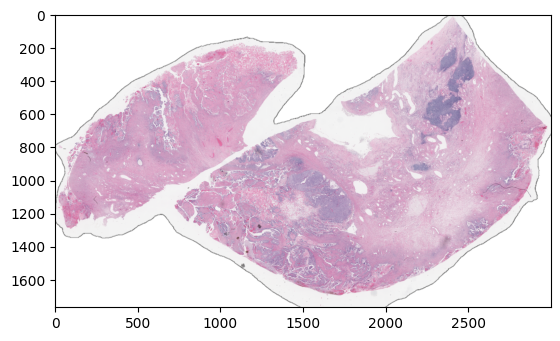

x=(616,2382), y=(0,1766)


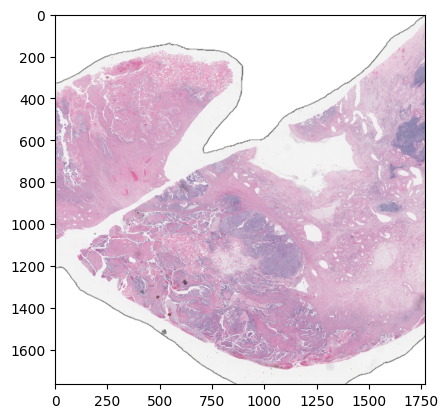

In [29]:
i = 7 # 3,7

file_path = df.file_path.values[i]
image_id  = df.image_id.values[i]

img = plt.imread(file_path)
plt.imshow(img)
plt.show()

for img in get_cropped_images(file_path, image_id, None, th_area=1000, return_image=True):
    plt.imshow(img)
    plt.show()

In [30]:
# crop image
print('Image Crop')
crop_df = Parallel(n_jobs=os.cpu_count())(
    delayed(get_cropped_images)(file_path, image_id, label, th_area=1000, return_image=False)
    for file_path,image_id,label in tqdm(df[['file_path','image_id','label']].values,desc='crop')
)
crop_df = pd.concat(crop_df,axis=0).reset_index(drop=True)

# delete duplicated image
crop_df = crop_df.drop_duplicates(subset=["image_id", "sx", "ex", "sy", "ey"]).reset_index(drop=True)

Image Crop


crop:   0%|          | 0/538 [00:00<?, ?it/s]

In [31]:
crop_df[crop_df.image_id==281]

,image_id,file_path,sx,ex,sy,ey,label
3,281,/kaggle/input/image-preprocessed-ubc/train_pru...,0,1101,0,1101,3
4,281,/kaggle/input/image-preprocessed-ubc/train_pru...,1102,2203,0,1101,3


<br>

## method 2

In [32]:
# # 잘된 케이스 : 3, 8, 11
# # 이상하게 나뉜 케이스 : 7, 20
# i = 20

# file_path = df.file_path.values[i]
# image_id  = df.image_id.values[i]

# img = plt.imread(file_path)
# plt.imshow(img)
# plt.show()

In [33]:
# img = cv2.imread(file_path)

# # 그레이스케일 이미지로 변환
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # 임계값 처리하여 흰색 배경 찾기
# # 여기서는 배경이 흰색이므로 높은 임계값을 사용합니다.
# _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

# # 컨투어(경계) 찾기
# contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# cropped_list = []
# # 각 컨투어에 대해
# for i, contour in enumerate(contours):
#     # 컨투어의 영역이 너무 작으면 무시 (잡음 제거)
#     if cv2.contourArea(contour) < 5000:
#         continue

#     # 바운딩 박스 계산
#     x, y, w, h = cv2.boundingRect(contour)

#     # 이미지 자르기
#     cropped = img[y:y+h, x:x+w]
    
#     cropped_list.append(cropped)

In [34]:
# for cropped in cropped_list:
#     plt.imshow(cropped)
#     plt.grid()
#     plt.show()

<br>

# Normalization

In [35]:
def get_color_mean_std(img_path, sx, ex, sy, ey):
    img = np.array(Image.open(img_path))
    img = img[ sy:ey, sx:ex, : ]
    mask = np.sum(img[..., :3], axis=2) == 0
    img[mask, :] = 255
    if np.max(img) > 1.5:
        img = img / 255.0
    clr_mean = {i: np.mean(img[..., i]) for i in range(3)}
    clr_std = {i: np.std(img[..., i]) for i in range(3)}
    return clr_mean, clr_std

In [36]:
def normalizations(df, n_jobs=os.cpu_count()):
    clr_mean_std = Parallel(n_jobs=n_jobs)(
        delayed(get_color_mean_std)(file_path,sx,ex,sy,ey)
        for file_path,sx,ex,sy,ey in tqdm(df[['file_path','sx','ex','sy','ey']].values,desc='normalizations')
    )

    img_color_mean = pd.DataFrame([c[0] for c in clr_mean_std]).describe()
    img_color_std = pd.DataFrame([c[1] for c in clr_mean_std]).describe()

    img_color_mean = list(img_color_mean.T["mean"])
    img_color_std = list(img_color_std.T["mean"])
    
    return img_color_mean, img_color_std

In [37]:
# img_color_mean, img_color_std = normalizations(crop_df)

# print(f'{img_color_mean=}')
# print(f'{img_color_std=}')

# # without crop
# img_color_mean=[0.9001133967153825, 0.8353600807517803, 0.8962360255565811]
# img_color_std=[0.11116642528209666, 0.16542502014636812, 0.10758222882570265]

# with crop
img_color_mean=[0.9099105921297389, 0.8503578319400451, 0.90624604547801]
img_color_std=[0.10478636034627896, 0.15453931526271314, 0.10123684458412788]

<br>

# Prepare Dataset




In [38]:
class_counts = crop_df['label'].value_counts().sort_index().values / len(crop_df)
class_weights = 1 / class_counts
class_weights /= sum(class_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights

tensor([0.1495, 0.0687, 0.0628, 0.3071, 0.4120])

In [39]:
def bacc(output,label):
    output = output.detach().cpu().argmax(-1)
    label = label.detach().cpu()
    return balanced_accuracy_score(label,output)

In [40]:
class UBCDataset(Dataset):
    def __init__(self, df, transforms=None, is_test=False):
        self.df = df
        self.file_paths = df['file_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        self.is_test = is_test
        
        if not self.is_test:
            self.sxs = df['sx'].values
            self.exs = df['ex'].values
            self.sys = df['sy'].values
            self.eys = df['ey'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        file_path = self.file_paths[index]
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if not self.is_test:
            sx, ex, sy, ey = self.sxs[index], self.exs[index], self.sys[index], self.eys[index]
            img = img[ sy:ey, sx:ex, : ]

        if self.transforms:
            img = self.transforms(Image.fromarray(img))
            
        if self.is_test:
            return img
        else:
            label = self.labels[index]
            return img, torch.tensor(label, dtype=torch.long)            

In [41]:
# img_color_mean, img_color_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# img_color_mean, img_color_std = [0.9001133967153825, 0.8353600807517803, 0.8962360255565811],\
#                                 [0.11116642528209666, 0.16542502014636812, 0.10758222882570265]
img_color_mean, img_color_std = [0.9099105921297389, 0.8503578319400451, 0.90624604547801],\
                                [0.10478636034627896, 0.15453931526271314, 0.10123684458412788]

transforms = {
    'train' : T.Compose([
                T.Resize((CFG.IMG_SIZE,CFG.IMG_SIZE)),
                #A.CenterCrop(512),
                #T.RandomResizedCrop(512, interpolation=InterpolationMode.BICUBIC, antialias=True),
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomRotation(degrees=10),
                T.ColorJitter(),
                T.ToTensor(),
                T.Normalize(img_color_mean, img_color_std),
            ]),
    'valid' : T.Compose([
                T.Resize((CFG.IMG_SIZE,CFG.IMG_SIZE)),
                #T.CenterCrop(512),
                T.ToTensor(),
                T.Normalize(img_color_mean, img_color_std),
            ]),
}

<br>

# Train

In [42]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path:str=None, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: None
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        # if self.verbose:
        #     self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if self.path is not None:
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [43]:
def train(
    model, train_loader, valid_loader, criterion, custom_metric, epochs,
    optimizer, scheduler=None, early_stopping=None, device='cpu', metric_period=1,
    verbose=True, save_dir = './checkpoints',
):
    model.to(device)
    criterion.to(device)

    best_loss  = 999999999
    best_epoch = 1
    best_model = None
    is_best    = np.nan
    best_model_state = deepcopy(model.state_dict())
    
    start_time = time.time()
    epoch_s = time.time()
    train_batch_num = 0
    for epoch in range(1, epochs+1):
        
        # training step
        train_loss = 0
        train_metric_value = 0
        pbar = tqdm(train_loader,desc='Train')
        model.train()
        for img, label in pbar:
            img = img.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            output = model(img)#.float()
            
            loss = criterion(output, label)
            metric_value = custom_metric(output, label)
            
            loss.backward()  # Getting gradients
            optimizer.step() # Updating parameters
            
            train_loss += loss.item()
            train_metric_value += metric_value
            train_batch_num += 1
            
            desc = '[Train] loss: {:.4f}, metric: {:.4f}'.format(loss.item(),metric_value)
            pbar.set_description(desc)
            
        train_loss /= train_batch_num
        train_metric_value /= train_batch_num

        # valiation step
        valid_loss = 0
        valid_metric_value = 0
        valid_batch_num = 0
        pbar = tqdm(valid_loader,desc='Validation')
        model.eval()
        with torch.no_grad():
            for img, label in pbar:
                img = img.to(device)
                label = label.to(device)
                output = model(img)#.float()

                loss = criterion(output, label)
                metric_value = custom_metric(output, label)
                
                valid_loss += loss.item()
                valid_metric_value += metric_value
                valid_batch_num += 1
                
                desc = '[Validation] loss: {:.4f}, metric: {:.4f}'.format(loss.item(),metric_value)
                pbar.set_description(desc)

            valid_loss /= valid_batch_num
            valid_metric_value /= valid_batch_num

        epoch_e = time.time()
            
        if scheduler is not None:
            scheduler.step(valid_loss)

        # update the best epoch & best loss
        if (best_loss > valid_loss) | (epoch==1):
            best_epoch = epoch
            best_loss = valid_loss
            best_model = model
            is_best = 1
            best_model_state = deepcopy(model.state_dict())
            save_path = os.path.join(save_dir,'epoch({})-val_loss({:.3f}).pt'.format(epoch,valid_loss))
            torch.save(best_model_state, save_path)
        else:
            is_best = 0
            
        # 결과물 printing
        if (verbose) & (epoch % metric_period == 0):
            mark = '*' if is_best else ' '
            epoch_str = str(epoch).zfill(len(str(epochs)))
            progress = '{}[{}/{}] loss: {:.4f}, metric: {:.4f}, val_loss: {:.4f}, val_metric: {:.4f}, best_epoch: {}, elapsed: {:.2f}s, total: {:.2f}s, remaining: {:.2f}s'\
                .format(
                    mark,
                    epoch_str,
                    epochs,
                    train_loss,
                    train_metric_value,
                    valid_loss,
                    valid_metric_value,
                    best_epoch,
                    epoch_e-epoch_s,
                    epoch_e-start_time,
                    (epoch_e-epoch_s)*(epochs-epoch)/metric_period,
                )
            epoch_s = time.time()
            print(progress)

        # early stopping 여부를 체크. 현재 과적합 상황 추적
        if early_stopping is not None:
            early_stopping(valid_loss, model)
            if early_stopping.early_stop:
                break
                
        #print(model.state_dict()['linear.weight'])

    model.load_state_dict(best_model_state)
    return best_model

In [44]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

In [45]:
class UBCModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True):
        super().__init__()
        self.num_classes = num_classes
        
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.arch = self.model.pretrained_cfg.get('architecture')
        # for param in self.model.parameters():
        #     param.requires_grad = False
        
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.fc(pooled_features)
        return output

In [46]:
# .iloc[:50]
train_data, val_data = train_test_split(crop_df, test_size=0.2, shuffle=True, 
                                        random_state=CFG.SEED, stratify=crop_df['label'])

train_dataset = UBCDataset(train_data, transforms['train'], is_test=False)
valid_dataset = UBCDataset(val_data  , transforms['valid'], is_test=False)

train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, num_workers=2, shuffle=False, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.BATCH_SIZE, num_workers=2, shuffle=False, pin_memory=True)

In [47]:
# image = [img for img,label in train_loader][0]

In [48]:
lr = 5e-4

In [49]:
# model = UBCModel(CFG.MODEL_NAME,CFG.NUM_CLASSES,pretrained=True) # for train
model = UBCModel(CFG.MODEL_NAME,CFG.NUM_CLASSES,pretrained=False)  # for submission
model = model.to(CFG.DEVICE)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# optimizer = torch.optim.AdamW(params = model.parameters(), lr=lr)#, weight_decay=1e-5)
# optimizer = torch.optim.SGD(params = model.parameters(), lr=lr, momentum=0.9)
optimizer = AdaBound(model.parameters(), lr=lr)
#optimizer = RAdam(self.parameters(), lr=lr)
#optimizer = Lion(self.parameters(), lr=lr, weight_decay=1e-2)
#optimizer = Adan(self.parameters(), lr=self.learn_rate * 10, betas=(0.02, 0.08, 0.01), weight_decay=0.02)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs',min_lr=1e-7, verbose=True)
scheduler = None

# early_stopping = EarlyStopping(patience=10, verbose=True, path=None)
early_stopping = None

In [50]:
# summary(model,input_size=(3,256,256))

In [51]:
# imgs = [img for img,label in valid_loader][0]
# labels = [label for img,label in valid_loader][0]
# validation(model, valid_loader, criterion, custom_metric, 'cuda')

In [52]:
flush()

In [53]:
# epochs = 128

# best_model = train(
#     model,
#     train_loader, valid_loader,
#     criterion, bacc,
#     epochs,
#     optimizer, scheduler, early_stopping,
#     device = 'cuda',
#     metric_period = 1,
#     verbose = True,
#     save_dir = f'checkpoints/{CFG.MODEL_NAME}_{CFG.IMG_SIZE}',
# )

In [54]:
flush()

In [55]:
# sorted(glob.glob(f'checkpoints/{CFG.MODEL_NAME}_{CFG.IMG_SIZE}/*'))
# !cp 'checkpoints/efficientnet_b0_1024/epoch(4)-val_loss(1.233).pt' 'epoch(4)-val_loss(1.233).pt'

<br>

# Check Performance

In [56]:
def predict(model, test_loader, device):
    model.to(device)
    model.eval()
    outputs = []
    with torch.no_grad():
        for img in tqdm(test_loader,desc='test batch'):
            img = img.to(device)
            output = model(img)#.float()
            outputs.append(output)
    
    outputs = torch.cat(outputs)
    
    probas = F.softmax(outputs,dim=1).data.squeeze()
    preds = torch.argmax(outputs,dim=1)
    
    return preds.detach().cpu().numpy(), probas.detach().cpu().numpy()

In [57]:
print('Saved Model Load')

# path = 'checkpoints/efficientnet_b0_1024/epoch(4)-val_loss(1.233).pt'
path = '/kaggle/input/model-checkpoints-ubc/epoch(4)-val_loss(1.233).pt'

model = UBCModel(CFG.MODEL_NAME,CFG.NUM_CLASSES,pretrained=False)
model.to(CFG.DEVICE)
model.load_state_dict(torch.load(path))

Saved Model Load


<All keys matched successfully>

In [58]:
print('Data Loader')

# train_dataset = UBCDataset(train_data, transforms['valid'], is_test=True)
# train_loader  = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, num_workers=2, shuffle=False, pin_memory=True)

# valid_dataset = UBCDataset(val_data, transforms['valid'], is_test=True)
# valid_loader  = DataLoader(valid_dataset, batch_size=CFG.BATCH_SIZE, num_workers=2, shuffle=False, pin_memory=True)

test_dataset = UBCDataset(df_sub, transforms['valid'], is_test=True)
test_loader  = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=True)

Data Loader


In [59]:
print('Prediction')

# train_preds, train_probas = predict(model, train_loader, CFG.DEVICE)
# valid_preds, valid_probas = predict(model, valid_loader, CFG.DEVICE)
test_preds, test_probas = predict(model, test_loader, CFG.DEVICE)

Prediction


test batch:   0%|          | 0/1 [00:00<?, ?it/s]

In [60]:
def highlight_diag(df):
    a = np.full(df.shape, '', dtype='<U24')
    np.fill_diagonal(a, 'background-color: yellow')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

def performances(preds,data):
    display(pd.crosstab(preds, data['label']).style.apply(highlight_diag, axis=None))
    for score_fn in [accuracy_score, f1_score, balanced_accuracy_score]:
        if score_fn.__name__=='f1_score':
            score = score_fn(preds, data['label'],average='macro')
        else:
            score = score_fn(preds, data['label'])
        print(f'{score_fn.__name__}: {100*score:.2f}%')

In [61]:
# performances(train_preds,train_data)
# performances(valid_preds,val_data)

<br>

# Reference (Pytorch Lightning)

In [62]:
class UBCDataModule(pl.LightningDataModule):
    def __init__(
        self,
        df,
        batch_size: int = 32,
        num_workers: int = None,
        transforms = {'train': None, 'valid': None},
    ):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.num_workers = num_workers or mp.cpu_count()
        self.train_dataset = None
        self.valid_dataset = None
        self.train_transforms = transforms['train']
        self.valid_transforms = transforms['valid']

    def prepare_data(self):
        pass

    @property
    def num_classes(self) -> int:
        assert self.train_dataset and self.valid_dataset
        return len(set(self.train_dataset.labels_unique + self.valid_dataset.labels_unique))

    def setup(self, stage=None):
        train_data, val_data = train_test_split(self.df, test_size=0.2, shuffle=True, 
                                                random_state=CFG.SEED, stratify=self.df['label'])

        self.train_dataset = UBCDataset(train_data, self.train_transforms)
        self.valid_dataset = UBCDataset(val_data  , self.valid_transforms)
        #self.test_dataset  = UBCDataset(self.df   , self.valid_transforms)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
        )

    def test_dataloader(self):
        pass
        # return DataLoader(
        #     self.test_dataset,
        #     batch_size=self.batch_size,
        #     num_workers=self.num_workers,
        #     shuffle=False,
        #     pin_memory=True,
        # )

In [63]:
class UBCModel(pl.LightningModule):

    def __init__(self, net, lr: float = 1e-4):
        super().__init__()
        self.net = net
        self.arch = net.pretrained_cfg.get('architecture')
        self.num_classes = net.num_classes
        self.learn_rate = lr
        self.accuracy = MulticlassAccuracy(num_classes=self.num_classes)
        self.f1_score = MulticlassF1Score(num_classes=self.num_classes)
        self.balanced_accuracy = bacc
        self.softmax = nn.Softmax(dim=1)
        
        self.net.to(self.device)
        
#         self.train_step_outputs = []
#         self.validation_step_outputs = []
        
        if TV_GE_0_16:
            # expriment with CutMix | MixUp with torch 2.1+
            # https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#where-to-use-mixup-and-cutmix
            cutmix = v2.CutMix(num_classes=net.num_classes)
            mixup = v2.MixUp(num_classes=net.num_classes)
            self.cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

    def forward(self, x):
        y = self.net(x)
        y = self.softmax(y)
        if y.isnan().any():
            y = torch.ones_like(y) / self.num_classes
        return y

    def compute_loss(self, y_hat, y):
        return F.cross_entropy(y_hat, y).to(self.device)

    def training_step(self, batch, batch_idx):
        perf = self.__share_step(batch, 'train')
        #self.train_step_outputs.append(perf)
    
    def validation_step(self, batch, batch_idx):
        perf = self.__share_step(batch, 'val')
        #self.validation_step_outputs.append(perf)
        
    def test_step(self, batch, batch_idx):
        perf = self.__share_step(batch, 'test')
        
    def __share_step(self, batch, mode):
        flush()
        
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        
        p_hat = self(x)
        y_hat = torch.argmax(p_hat, axis=1)
        
        loss = self.compute_loss(p_hat, y)
        acc_score  = self.accuracy(y_hat, y)
        f1_score   = self.f1_score(y_hat, y)
        bacc_score = self.balanced_accuracy(p_hat, y)

        self.log(f"{mode}_loss", loss, logger=True, prog_bar=True)
        self.log(f"{mode}_acc", acc_score, logger=True, prog_bar=False)
        self.log(f"{mode}_f1", f1_score, logger=True, prog_bar=False)
        self.log(f"{mode}_bacc", bacc_score, logger=True, prog_bar=True)
        
        return loss
        
    #     return {
    #         'loss': loss,
    #         'acc': acc_score,
    #         'f1': f1_score,
    #         'bacc': torch.tensor(bacc_score),
    #     }

    # def on_train_epoch_end(self):
    #     self.__share_epoch_end('train')
    #     self.train_step_outputs.clear()

    # def on_validation_epoch_end(self):
    #     self.__share_epoch_end('val')
    #     self.validation_step_outputs.clear()

    # def __share_epoch_end(self, mode):
    #     if mode=='train':
    #         outputs = self.train_step_outputs
    #     elif mode=='val':
    #         outputs = self.validation_step_outputs

    #     avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
    #     avg_acc  = torch.stack([x['acc'] for x in outputs]).mean()
    #     avg_f1   = torch.stack([x['f1'] for x in outputs]).mean()
    #     avg_bacc = torch.stack([x['bacc'] for x in outputs]).mean()

    #     self.log(f"{mode}_loss", avg_loss, logger=True, prog_bar=True)
    #     self.log(f"{mode}_acc", avg_acc, logger=True, prog_bar=False)
    #     self.log(f"{mode}_f1", avg_f1, logger=True, prog_bar=False)
    #     self.log(f"{mode}_bacc", avg_bacc, logger=True, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer = AdaBound(self.parameters(), lr=self.learn_rate)
        #optimizer = RAdam(self.parameters(), lr=self.learn_rate)
        #optimizer = torch.optim.AdamW(self.parameters(), lr=self.learn_rate)
        #optimizer = Lion(self.parameters(), lr=self.learn_rate, weight_decay=1e-2)
        #optimizer = Adan(self.parameters(), lr=self.learn_rate * 10, betas=(0.02, 0.08, 0.01), weight_decay=0.02)
        
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        #    optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6, verbose=True)
        scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer, base_lr=self.learn_rate, max_lr=self.learn_rate * 5,
            step_size_up=5, cycle_momentum=False, mode="triangular2", verbose=True)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(
        #    optimizer, max_lr=self.learn_rate * 5, steps_per_epoch=1, epochs=self.trainer.max_epochs)
        return [optimizer], [scheduler]

In [64]:
# net = timm.create_model(CFG.MODEL_NAME, pretrained=True, num_classes=CFG.NUM_CLASSES)
# model = UBCModel(net, lr=1e-4)

In [65]:
# from pytorch_lightning.callbacks import EarlyStopping
# logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.arch)
# es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=True)
# mc = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=5, dirpath='mc', filename="checkpoint-{epoch:03d}-{val_loss:.2f}")
# # "val_loss" metric이 높은 상위 5개 checkpoint를 저장

# # ==============================

# trainer = pl.Trainer(
#     accelerator="cuda",
#     devices=1,
#     logger=logger,
#     max_epochs=128,
#     #precision=16,
#     #accumulate_grad_batches=14,
#     callbacks=[mc],#[es,mc],
#     #fast_dev_run=True,
#     #val_check_interval=0.5,
# )

# # ==============================

# # trainer.tune(model, datamodule=datamodule)
# trainer.fit(model=model, datamodule=datamodule)

In [66]:
# model = UBCModel.load_from_checkpoint(model_path, net=net, lr=1e-4)
# model.eval()

# with torch.no_grad():
#     output_list = []
#     label_list = []
#     for img,label in tqdm(datamodule.test_dataloader()):
#         img = img.to(CFG.DEVICE)
#         label = label.to(CFG.DEVICE)
        
#         output = model(img)
        
#         output_list.append(output)
#         label_list.append(label)

In [67]:
# pred = torch.argmax(torch.cat(output_list),axis=1).detach().cpu().numpy()
# true = torch.cat(label_list).detach().cpu().numpy()
# pd.crosstab(true,pred)

<br>

# Inference

In [68]:
print('Inference')

# df_sub = pd.read_csv('/kaggle/input/UBC-OCEAN/sample_submission.csv')
df_sub['label'] = test_preds
df_sub['label'] = df_sub['label'].map(label2id)
df_sub[["image_id", "label"]].to_csv("submission.csv", index=False)

Inference


In [69]:
# pd.read_csv('submission.csv')